# import modules and functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import json

import catboost as cat
#import shap


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

/Users/azbukinanadezda/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def read_json(file_name):
    
    with open(file_name, "r") as read_file:
        data = json.load(read_file)
    return(pd.DataFrame(data).T)

In [3]:
#make binary from ss and coevol
#ss bound - 95-98
#coevolution 105-112

def make_binary_disulf(ao_lists):
    result = ["1" if pair == ["C", "C"] else "0" for pair in ao_lists]
    return(result)
    


In [4]:
def feature_selection(clf, x_test, y_test, cat_feautures):
    
    indexes_of_categories = [x_train.columns.get_loc(col) for col in cat_feautures]
    shap_values = clf.get_feature_importance(cat.Pool(x_test, label=y_test,
                                                      cat_features=indexes_of_categories), 
                                                                     type="ShapValues")
    #meanings 
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    
    #plot importance
    shap.summary_plot(shap_values, x_test, plot_type="bar")
    
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
    feature_importance.reset_index(drop=True,inplace = True) 
    
    return(feature_importance)

# read files and prepare test/train//val

In [5]:
f29p = read_json("positive.json")
#f29n = read_json("negative_set_polb.json")
f29n = read_json("search_set_filtered_viral_v2.json")
f29p["target"] = [1 for i in range(f29p.shape[0])]
f29n["target"] = [0 for i in range(f29n.shape[0])]

f29 = pd.concat([f29p, f29n])
f29.shape

(2185, 11)

In [6]:
f29.head()

,catalytic,dntp_binding,primer_binding,exonuclease,Mg,replication_activity,conservative,ssbonds,pockets,coevolution,target
tr|A0A2S1GQF7|A0A2S1GQF7_9CAUD,"[M, P, P]","[Y, Q, K, A, G, Y, Y]","[V, S, D, V, N, R, -, F]","[A, Q, K, E, M, L, L, Y, K, Y, Y, N, A, G, C, P]","[K, N, D, L, M, P]","[F, N, Y, F, M, F, P, G, A, -, D, S, Y, S, N, ...","[P, Y, D, G, S, L, K, Y, I, V, D, L, K, G, E, ...","[[I, M], [V, L], [F, V], [N, C]]","[I, -, -, -, V, -]","[[G, Y], [N, G], [N, Q], [G, V], [N, -], [F, V...",1
tr|A0A0M9JDK6|A0A0M9JDK6_9CAUD,"[M, P, P]","[Y, Q, K, A, G, Y, Y]","[V, S, D, V, N, R, -, F]","[A, Q, K, E, M, L, L, Y, K, Y, Y, N, A, G, C, P]","[K, N, D, L, M, P]","[F, N, Y, F, M, F, P, G, A, -, D, S, Y, S, N, ...","[P, Y, D, G, S, L, K, Y, I, V, D, L, K, G, E, ...","[[I, M], [V, L], [F, V], [N, C]]","[I, -, -, -, V, -]","[[G, Y], [N, G], [N, Q], [G, V], [N, -], [F, V...",1
tr|C7BV40|C7BV40_9CAUD,"[S, P, Y]","[Y, R, K, A, S, Y, W]","[V, S, D, L, S, R, -, V]","[E, H, K, E, M, L, L, Y, E, H, F, N, A, S, N, P]","[K, N, D, L, S, P]","[F, S, F, Y, V, Y, A, G, A, -, D, S, Y, S, S, ...","[P, Y, D, G, S, L, K, Y, I, V, D, L, K, G, E, ...","[[C, H], [A, F], [F, I], [N, L]]","[L, -, -, -, V, -]","[[G, Y], [N, G], [N, Q], [G, L], [N, -], [F, V...",1
tr|A0A0E3HLI0|A0A0E3HLI0_9CAUD,"[S, P, Y]","[Y, R, K, A, S, Y, W]","[I, S, D, L, S, R, -, V]","[E, H, K, E, M, M, L, Y, S, H, F, N, A, S, N, P]","[K, N, D, L, S, P]","[F, S, F, Y, V, Y, A, G, A, -, D, S, Y, S, S, ...","[P, Y, D, G, S, L, K, Y, I, V, D, L, K, G, E, ...","[[C, H], [A, Y], [F, I], [N, L]]","[L, -, -, -, V, -]","[[G, Y], [N, G], [N, Q], [G, L], [N, -], [F, I...",1
tr|A0A249XWF2|A0A249XWF2_9CAUD,"[M, P, P]","[Y, Q, K, A, G, Y, W]","[I, S, D, V, N, R, -, F]","[T, K, K, E, L, L, L, Y, K, Y, Y, N, A, A, C, P]","[K, N, D, L, M, P]","[F, T, Y, F, M, Y, P, G, A, -, D, S, Y, S, N, ...","[P, Y, D, G, S, L, K, Y, I, V, D, L, K, G, E, ...","[[V, V], [A, L], [F, V], [N, L]]","[I, -, -, -, V, -]","[[G, Y], [N, G], [N, Q], [G, V], [N, -], [F, V...",1


In [7]:
f29 = f29.drop(columns=["coevolution"])
f29.ssbonds = f29.ssbonds.apply(make_binary_disulf)

In [8]:
new_colnames = [] 
counter = 0
for i, j in zip(f29.columns[:-1], f29.iloc[0, :]):
    for k in range(len(j)):
        new_colnames.append(str(counter)+'_'+i+'_'+str(k))
        counter += 1
        


In [9]:
#make labels 
f29_label = pd.DataFrame()
for i in f29.columns: 
    f29_label = pd.concat([f29_label, pd.DataFrame(f29[i].tolist(), index= f29.index)], axis = 1)

f29_label.columns = new_colnames + ["target"] 

In [10]:
f29_label

,0_catalytic_0,1_catalytic_1,2_catalytic_2,3_dntp_binding_0,4_dntp_binding_1,5_dntp_binding_2,6_dntp_binding_3,7_dntp_binding_4,8_dntp_binding_5,9_dntp_binding_6,...,96_ssbonds_1,97_ssbonds_2,98_ssbonds_3,99_pockets_0,100_pockets_1,101_pockets_2,102_pockets_3,103_pockets_4,104_pockets_5,target
tr|A0A2S1GQF7|A0A2S1GQF7_9CAUD,M,P,P,Y,Q,K,A,G,Y,Y,...,0,0,0,I,-,-,-,V,-,1
tr|A0A0M9JDK6|A0A0M9JDK6_9CAUD,M,P,P,Y,Q,K,A,G,Y,Y,...,0,0,0,I,-,-,-,V,-,1
tr|C7BV40|C7BV40_9CAUD,S,P,Y,Y,R,K,A,S,Y,W,...,0,0,0,L,-,-,-,V,-,1
tr|A0A0E3HLI0|A0A0E3HLI0_9CAUD,S,P,Y,Y,R,K,A,S,Y,W,...,0,0,0,L,-,-,-,V,-,1
tr|A0A249XWF2|A0A249XWF2_9CAUD,M,P,P,Y,Q,K,A,G,Y,W,...,0,0,0,I,-,-,-,V,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tr|G9I044|G9I044_HZNV2,A,G,V,Y,K,K,K,S,Y,I,...,0,0,0,L,-,-,-,N,-,0
tr|A0A2Z4H5C0|A0A2Z4H5C0_HHV1,F,A,G,L,R,G,I,T,S,L,...,0,0,0,G,H,L,L,S,L,0
tr|D7F5T1|D7F5T1_9ABAC,E,L,-,N,L,E,Y,L,L,N,...,0,0,0,F,-,-,-,T,-,0
tr|A0A4Y5QKF2|A0A4Y5QKF2_HHV2,F,A,P,L,R,G,I,T,S,L,...,0,0,0,G,H,L,L,S,L,0


In [11]:
# choose for validation 
x_train, x_val, y_train, y_val = train_test_split(f29_label.drop("target",
                                                            axis=1),
                                                    f29_label['target'],
                                                    test_size=0.2,
                                                    random_state=42)
x_train.reset_index(drop=True,inplace = True)  
x_val.reset_index(drop=True,inplace = True)  
y_train.reset_index(drop=True,inplace = True)  
y_val.reset_index(drop=True,inplace = True)  

In [12]:
# choose for test/train
x_train, x_test, y_train, y_test = train_test_split(f29_label.drop("target",
                                                            axis=1),
                                                    f29_label['target'],
                                                    test_size=0.2,
                                                    
                                                    random_state=42)
x_train.reset_index(drop=True,inplace = True)  
x_test.reset_index(drop=True,inplace = True)  
y_train.reset_index(drop=True,inplace = True)  
y_test.reset_index(drop=True,inplace = True)  

In [13]:
x_train

,0_catalytic_0,1_catalytic_1,2_catalytic_2,3_dntp_binding_0,4_dntp_binding_1,5_dntp_binding_2,6_dntp_binding_3,7_dntp_binding_4,8_dntp_binding_5,9_dntp_binding_6,...,95_ssbonds_0,96_ssbonds_1,97_ssbonds_2,98_ssbonds_3,99_pockets_0,100_pockets_1,101_pockets_2,102_pockets_3,103_pockets_4,104_pockets_5
0,Q,D,G,Y,E,Y,Y,G,M,W,...,0,0,0,0,L,-,-,-,V,-
1,S,P,Y,Y,K,H,A,G,Y,Y,...,0,0,0,0,L,-,-,-,V,-
2,-,S,E,Y,N,K,Y,G,F,S,...,0,0,0,0,I,-,-,-,V,-
3,A,R,P,Y,L,Y,Y,G,F,F,...,0,0,0,0,L,-,-,-,V,-
4,N,A,K,Y,T,L,E,G,Y,E,...,0,0,0,0,A,-,-,-,K,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,P,G,A,Y,L,E,Y,N,F,T,...,0,0,0,0,F,-,-,-,V,-
1744,S,D,L,Y,R,F,Y,G,F,F,...,0,0,0,0,L,-,-,I,V,-
1745,E,V,L,Y,M,Y,Y,G,F,F,...,0,0,0,0,L,-,-,-,V,-
1746,A,P,T,Y,L,V,N,P,Y,Y,...,0,0,0,0,I,-,-,-,V,-


# Hyperparameters search and feature selection

In [14]:
cat_feautures = x_train.columns
indexes_of_categories = [x_train.columns.get_loc(col) for col in cat_feautures]

In [15]:
params = {
    'depth': [1, 4, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.15,0.2,0.5],
    'loss_function': ['Logloss', 'CrossEntropy'],
    'l2_leaf_reg': np.logspace(0.01, 2, 20),
    'leaf_estimation_iterations': [10],
    'logging_level': ['Silent'],
    'random_seed': [42],
    'iterations':[i for i in range(100, 1000, 100)]
}

In [16]:
clf = cat.CatBoostClassifier(eval_metric="F1",cat_features=indexes_of_categories)

In [ ]:
grid = RandomizedSearchCV(clf,
                          params,
                          n_jobs=1,
                          n_iter=10,
                          scoring="f1",
                          cv=5, 
                          verbose= 3)

grid.fit(x_train, y_train, cat_features=indexes_of_categories)
best_params = grid.best_estimator_.get_params()я

In [18]:
print(best_params)

{'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104], 'eval_metric': 'F1', 'random_seed': 42, 'loss_function': 'Logloss', 'logging_level': 'Silent', 'learning_rate': 0.2, 'leaf_estimation_iterations': 10, 'l2_leaf_reg': 2.685019032003968, 'iterations': 700, 'depth': 4}


In [19]:
clf_cat = cat.CatBoostClassifier(**best_params).fit(x_train, y_train,cat_features=indexes_of_categories)
y_pred = clf_cat.predict(x_test)
y_pred_proba = clf_cat.predict_proba(x_test)[:,-1]

In [20]:
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       383
           1       0.98      1.00      0.99        54

    accuracy                           1.00       437
   macro avg       0.99      1.00      0.99       437
weighted avg       1.00      1.00      1.00       437

0.9986945169712793


In [21]:
path = "models/"
model_name = "first_model_viral"
clf_cat.save_model(path + "/" + model_name)

In [22]:
labelsdf = pd.DataFrame()
labelsdf['target'] = y_pred
labelsdf['proba'] = y_pred_proba

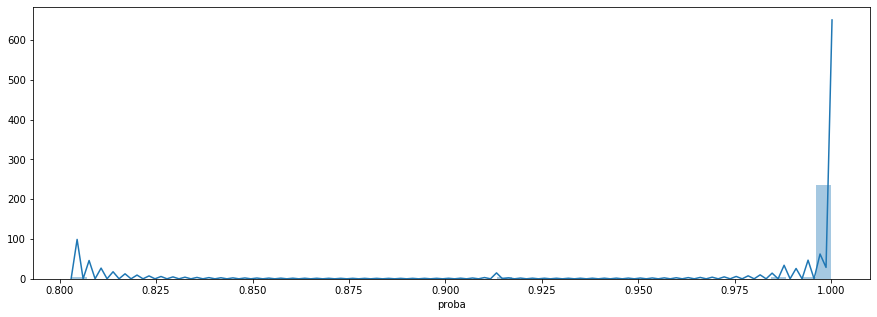

In [25]:
plt.figure(figsize=(15,5))
sns.distplot(labelsdf[labelsdf['target']==1]['proba'])



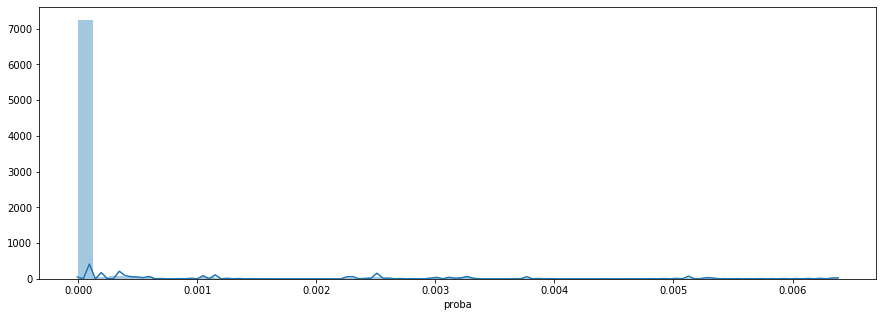

In [26]:
plt.figure(figsize=(15,5))
sns.distplot(labelsdf[labelsdf['target']==0]['proba'])

# evaluate shap_values

In [27]:
clf_cat = cat.CatBoostClassifier() # parameters not required.
clf_cat.load_model(path + "/" + model_name)


In [28]:
shap_values = clf_cat.get_feature_importance(cat.Pool(x_test, label=y_test,
                                                      cat_features=indexes_of_categories), 
                                                                     type="ShapValues")

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
values = np.abs(shap_values).mean(0)

In [29]:
report = pd.DataFrame()
report['features'] = x_test.columns
report['shap_values'] = values

In [30]:
report = report.sort_values(by='shap_values')
report

,features,shap_values
104,104_pockets_5,0.000000
1,1_catalytic_1,0.000000
81,81_conservative_20,0.000000
3,3_dntp_binding_0,0.000000
51,51_replication_activity_11,0.000000
...,...,...
27,27_exonuclease_9,0.412569
93,93_conservative_32,0.622999
67,67_conservative_6,0.829289
28,28_exonuclease_10,1.112829


(array([9., 2., 0., 1., 0., 1., 0., 1., 0., 1.]),
 array([0.20873512, 0.33193332, 0.45513151, 0.57832971, 0.70152791,
        0.8247261 , 0.9479243 , 1.07112249, 1.19432069, 1.31751889,
        1.44071708]),
 <a list of 10 Patch objects>)

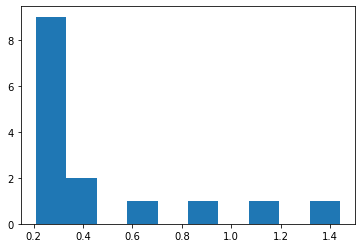

In [31]:
plt.hist(report['shap_values'][-15:])

In [62]:
data = report.iloc[-15:,:].copy()
data.head()

,features,shap_values
5,5_dntp_binding_2,0.208735
101,101_pockets_2,0.234352
14,14_primer_binding_4,0.237203
43,43_replication_activity_3,0.247800
15,15_primer_binding_5,0.249840


In [80]:
data.to_csv('features_selected_viral.csv',index=False)


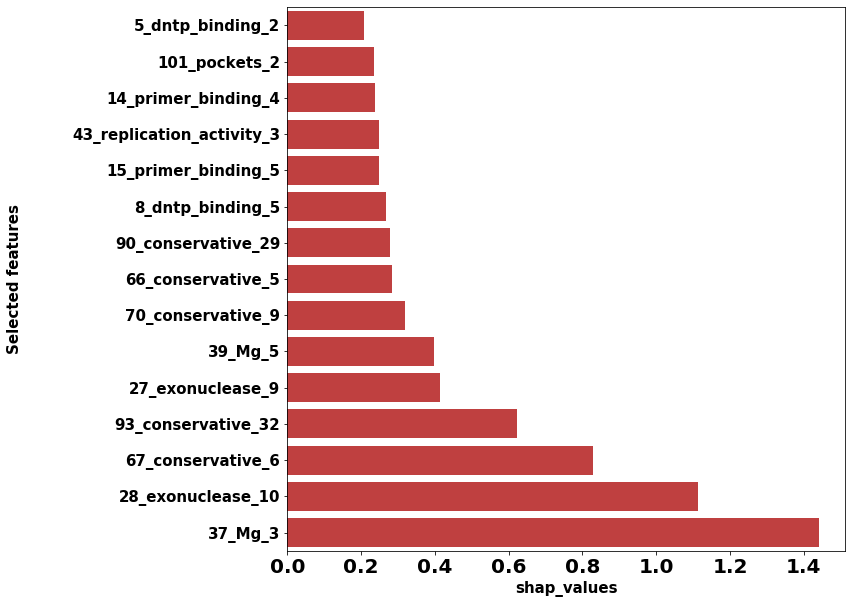

In [78]:
plt.figure(figsize=(10,10))
a = sns.barplot(x="shap_values", y="features", data=data,color="red", saturation=.5)
plt.xticks(size=20, weight='extra bold', )

plt.yticks(size=15, weight='extra bold')
plt.xlabel('shap_values',size = 15, weight='extra bold') 
plt.ylabel('Selected features', size=15,  weight='extra bold', labelpad=50)
fig = a.get_figure()
fig.savefig('selected_features.png', bbox_inches="tight", dpi = 300)

In [37]:
selected = report.tail(15)['features'].values.tolist()
selected

['5_dntp_binding_2',
 '101_pockets_2',
 '14_primer_binding_4',
 '43_replication_activity_3',
 '15_primer_binding_5',
 '8_dntp_binding_5',
 '90_conservative_29',
 '66_conservative_5',
 '70_conservative_9',
 '39_Mg_5',
 '27_exonuclease_9',
 '93_conservative_32',
 '67_conservative_6',
 '28_exonuclease_10',
 '37_Mg_3']

In [38]:
#shap.summary_plot(shap_values, x_test, plot_type="bar")

# Short model

In [39]:
#selected = selected 
x_train = x_train[selected]
x_val = x_val[selected]

In [40]:
cat_feautures = x_train.columns
indexes_of_categories = [x_train.columns.get_loc(col) for col in cat_feautures]

In [41]:
clf = cat.CatBoostClassifier(eval_metric="F1",cat_features=indexes_of_categories)

In [42]:
grid = RandomizedSearchCV(clf,
                          params,
                          n_jobs=1,
                          n_iter=10,
                          scoring="f1",
                          cv=5, 
                          verbose= 3)

grid.fit(x_train, y_train, cat_features=indexes_of_categories)
best_params = grid.best_estimator_.get_params()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1, score=0.978, total=  17.6s
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1, score=0.943, total=  11.3s
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.0s remaining:    0.0s


[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1, score=0.989, total=  12.3s
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1 
[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1, score=1.000, total=   8.2s
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1 
[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.15, leaf_estimation_iterations=10, l2_leaf_reg=38.11120070597852, iterations=500, depth=1, score=0.966, total=   8.6s
[CV] random_seed=42, loss_

[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.1, leaf_estimation_iterations=10, l2_leaf_reg=61.73426982315296, iterations=400, depth=10, score=0.978, total=  27.7s
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.2, leaf_estimation_iterations=10, l2_leaf_reg=7.045222880062048, iterations=300, depth=7 
[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.2, leaf_estimation_iterations=10, l2_leaf_reg=7.045222880062048, iterations=300, depth=7, score=0.977, total=   6.8s
[CV] random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.2, leaf_estimation_iterations=10, l2_leaf_reg=7.045222880062048, iterations=300, depth=7 
[CV]  random_seed=42, loss_function=CrossEntropy, logging_level=Silent, learning_rate=0.2, leaf_estimation_iterations=10, l2_leaf_reg=7.045222880062048, iterations=300, depth=7, score=0.967, total=   7.9s
[CV] random_seed=42, loss_func

[CV]  random_seed=42, loss_function=Logloss, logging_level=Silent, learning_rate=0.001, leaf_estimation_iterations=10, l2_leaf_reg=100.0, iterations=800, depth=4, score=0.926, total=  21.5s
[CV] random_seed=42, loss_function=Logloss, logging_level=Silent, learning_rate=0.001, leaf_estimation_iterations=10, l2_leaf_reg=100.0, iterations=800, depth=4 
[CV]  random_seed=42, loss_function=Logloss, logging_level=Silent, learning_rate=0.001, leaf_estimation_iterations=10, l2_leaf_reg=100.0, iterations=800, depth=4, score=0.900, total=  17.2s
[CV] random_seed=42, loss_function=Logloss, logging_level=Silent, learning_rate=0.001, leaf_estimation_iterations=10, l2_leaf_reg=100.0, iterations=800, depth=4 
[CV]  random_seed=42, loss_function=Logloss, logging_level=Silent, learning_rate=0.001, leaf_estimation_iterations=10, l2_leaf_reg=100.0, iterations=800, depth=4, score=0.889, total=  16.6s
[CV] random_seed=42, loss_function=Logloss, logging_level=Silent, learning_rate=0.001, leaf_estimation_ite

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 22.9min finished


In [43]:
print(best_params)

{'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'eval_metric': 'F1', 'random_seed': 42, 'loss_function': 'CrossEntropy', 'logging_level': 'Silent', 'learning_rate': 0.15, 'leaf_estimation_iterations': 10, 'l2_leaf_reg': 11.412174956056242, 'iterations': 500, 'depth': 7}


In [44]:
clf_cat = cat.CatBoostClassifier(**best_params).fit(x_train, y_train,cat_features=indexes_of_categories)
y_pred = clf_cat.predict(x_val)
y_pred_proba = clf_cat.predict_proba(x_val)[:,-1]

In [45]:
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       383
           1       0.98      1.00      0.99        54

    accuracy                           1.00       437
   macro avg       0.99      1.00      0.99       437
weighted avg       1.00      1.00      1.00       437

0.9986945169712793


In [46]:
path = "models/"
model_name = "feature__selected_model_viral"
clf_cat.save_model(path + "/" + model_name)

#  Validation bacteria

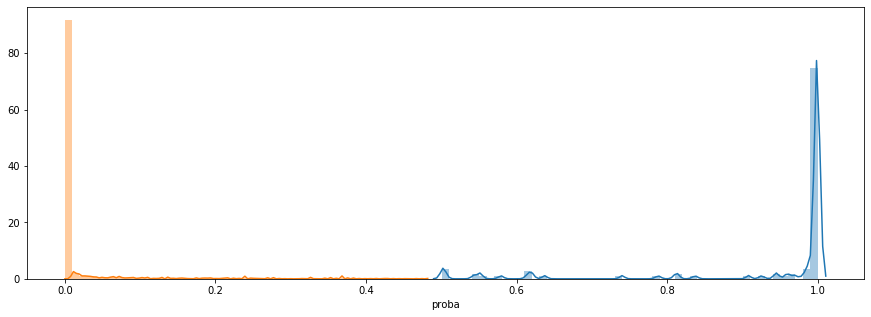

In [84]:
df = read_json("bacterial_pf00136_filtered_v2.json")

df = df.drop(columns=["coevolution"])
df.ssbonds = df.ssbonds.apply(make_binary_disulf)

new_colnames = [] 
counter = 0
for i, j in zip(df.columns[:], df.iloc[0, :]):
    for k in range(len(j)):
        new_colnames.append(str(counter)+'_'+i+'_'+str(k))
        counter += 1
        


df_label = pd.DataFrame()
for i in df.columns: 
    df_label = pd.concat([df_label, pd.DataFrame(df[i].tolist(), index= df.index)], axis = 1)

df_label.columns = new_colnames


selected = ['5_dntp_binding_2', '101_pockets_2', '14_primer_binding_4', '43_replication_activity_3',
 '15_primer_binding_5', '8_dntp_binding_5', '90_conservative_29', '66_conservative_5',
 '70_conservative_9', '39_Mg_5', '27_exonuclease_9', '93_conservative_32', '67_conservative_6',
 '28_exonuclease_10', '37_Mg_3']
df_label = df_label[selected]

clf_cat = cat.CatBoostClassifier() # parameters not required.
clf_cat.load_model(path + "/" + model_name)
y_pred = clf_cat.predict(df_label)
y_pred_proba = clf_cat.predict_proba(df_label)[:,-1]
labelsdf = pd.DataFrame()
labelsdf['target'] = y_pred
labelsdf['proba'] = y_pred_proba
plt.figure(figsize=(15,5))
sns.distplot(labelsdf[labelsdf['target']==1]['proba'])
sns.distplot(labelsdf[labelsdf['target']==0]['proba'])



In [87]:
df.columns

Index(['catalytic', 'dntp_binding', 'primer_binding', 'exonuclease', 'Mg',
       'replication_activity', 'conservative', 'ssbonds', 'pockets'],
      dtype='object')

In [58]:
n = len(y_pred)
pos = len([elem for elem in y_pred if elem == 1])
print('predicted '+str(pos)+' positives from '+str(n)+' queries')
print(str(round(pos/n*100,3))+'%')

predicted 110 positives from 7157 queries
1.537%


In [59]:
df_label['target'] = y_pred
my_list = df_label[df_label['target']==1].index

with open('bacterial_pf00136_predicted.txt', 'w') as f:
    for item in my_list:
        f.write("%s\n" % item)

# Virus  Validation

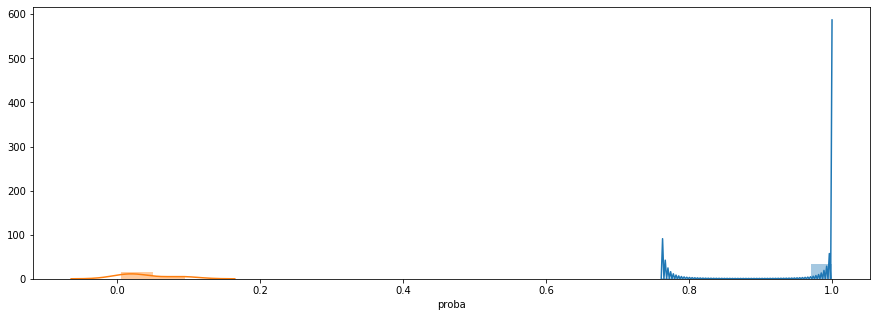

In [95]:
df = read_json("viral_proteins_2020_filtered.json")
df = df[['catalytic', 'dntp_binding', 'primer_binding', 'exonuclease', 'Mg',
       'replication_activity', 'conservative', 'ssbonds', 'pockets']]

#df = df.drop(columns=["coevolution"])
df.ssbonds = df.ssbonds.apply(make_binary_disulf)

new_colnames = [] 
counter = 0
for i, j in zip(df.columns[:], df.iloc[0, :]):
    for k in range(len(j)):
        new_colnames.append(str(counter)+'_'+i+'_'+str(k))
        counter += 1
        


df_label = pd.DataFrame()
for i in df.columns: 
    df_label = pd.concat([df_label, pd.DataFrame(df[i].tolist(), index= df.index)], axis = 1)

df_label.columns = new_colnames


selected = ['5_dntp_binding_2', '101_pockets_2', '14_primer_binding_4', '43_replication_activity_3',
 '15_primer_binding_5', '8_dntp_binding_5', '90_conservative_29', '66_conservative_5',
 '70_conservative_9', '39_Mg_5', '27_exonuclease_9', '93_conservative_32', '67_conservative_6',
 '28_exonuclease_10', '37_Mg_3']
df_label = df_label[selected]

clf_cat = cat.CatBoostClassifier() # parameters not required.
clf_cat.load_model(path + "/" + model_name)
y_pred = clf_cat.predict(df_label)
y_pred_proba = clf_cat.predict_proba(df_label)[:,-1]
labelsdf = pd.DataFrame()
labelsdf['target'] = y_pred
labelsdf['proba'] = y_pred_proba
plt.figure(figsize=(15,5))
sns.distplot(labelsdf[labelsdf['target']==1]['proba'])
sns.distplot(labelsdf[labelsdf['target']==0]['proba'])




In [97]:
df_label['target'] = y_pred
my_list = df_label[df_label['target']==1].index

with open('viral_predicted.txt', 'w') as f:
    for item in my_list:
        f.write("%s\n" % item)

In [94]:
n = len(y_pred)
pos = len([elem for elem in y_pred if elem == 1])
print('predicted '+str(pos)+' positives from '+str(n)+' queries')
print(str(round(pos/n*100,3))+'%')

predicted 76 positives from 86 queries
88.372%
